# Ploynomial Fitting and Historic Binwise Mean 

In [3]:
import pandas as pd
import numpy as np

In [1]:
# List the stocks of portfolios 
# L1: 10.16-11.1
L1='mac symc ctb pch vtr kim ivz ctb dre anf'.upper().split(' ')

# L2: 12.17-12.31
L2='fti tex tif sig hpq tjx sig fti sanm apc'.upper().split(' ')


<h3> Read corresponding trade data and quote 

In [5]:
# Prepare trade data and set indexes for quoting

df1=pd.read_csv('1016-1101_vwap.csv',header=0)
p_d1_ind=11 # index in data.npy
p_s1_ind=23

df2=pd.read_csv('1217-1231_vwap.csv',header=0)
p_d2_ind=53
p_s2_ind=62


C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Define Functions

In [6]:
# Separate and merge the volumes and prices into per minute data 
def Vol_Price_Separation(df_d):
    # Time list (%H:%m)
    T=[]
    # Volume list of each day (1 size per minute)
    s=[]
    # Price lis : use the price at the start of each minute to represent that minute price
    p=[]
    i=-1
    
    for j in range(len(df_d['TIME_M'])):
        # count the size as zero for the missing minute data
        # the price follows the previous minute if that corresponding minute is missing
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
            s.append(0)
            p.append(p[-1])
        # append a new minute bar
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p.append(np.array(df_d['PRICE'])[j])
            s.append(np.array(df_d['SIZE'])[j])
        # accumulate the size to the same minute
        else:
            s[i]+=np.array(df_d['SIZE'])[j]
    # count the size of 9:30 minute as zero if 9:30 is missing
    if '9:30' not in T:
        s=[0]+s
        p=[0]+p
    
    return s,p

In [7]:
# Calculate the Execution VWAP
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    # remaining volumes ？
    size_=size
    history=[]
    while size>0 and i<len(real_volume):
        
        goal=target_percentage[i]*size_
        # 
        if i==len(real_volume)-1:
            
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))


In [10]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Function: To calculate the Buying and Selling Execution VWAP and Benchmark VWAP
# (from real trade data) of a rebalancing phase for one stock
def VWAP_calc(ticker,capital,df,pd_ind,ps_ind):
    # Select the data for this stock
    df_t=df[df['SYM_ROOT']==ticker]
    # List the dates in the rebalancing phase
    D=sorted(list(set(df_t['DATE'])))
    # List of volumes for all the 30-min trading during the rebalancing phase
    St=[]# consisting of lists s: 30 minute-volume of each day
    
    S_t=[]
    
    # Separate the volumes by minute for each day (d)
    for d in D[:-1]:
        # select the data of date d
        df_d=df_t[df_t['DATE']==d]
        # per minute volume list of each day (d)
        s = Vol_Price_Separation(df_d)[0]
        # append the 30 minute-volumes
        if len(s)==30:
            St+=s
            S_t.append(s)
    
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    # Convert the per minute volumes into percentage volumes 
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    # Calculate the mean volumes of each minute for the past days
    hist_mean=np.mean(S_t,axis=0)
    
    # Time series
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    
    # print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    
    # Print(vol_mean)
    # Trading day: the first day of the rebalancing phase
    df_d=df_t[df_t['DATE']==D[0]]
    # Volume list s_start: same as s above
    # Price list: use the price at the start of each minute to represent that minute price
    s_start, p_start = Vol_Price_Separation(df_d)

    # Trading day: the last day of the rebalancing phase
    df_d=df_t[df_t['DATE']==D[-1]]
    s_end, p_end = Vol_Price_Separation(df_d)

    #print(T)
    Dict_=np.load('data.npy').item()
    # Cite the stock open price 
    p_d=np.array(Dict_[ticker.lower()]['Open'])[pd_ind]
    p_s=np.array(Dict_[ticker.lower()]['Open'])[ps_ind]
    cap=capital
    # Number of shares
    size=int(cap/p_d)
    hb,r,pb=execution(hist_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps=execution(hist_mean,size,s_end,p_end)
    size=int(cap/p_d)
    hb,r,pb2=execution(pred_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps2=execution(pred_mean,size,s_end,p_end)
    print('2018.10.16 (Buy)Decision Price:'+str(p_d)+' Executed VWAP(historic mean):'+str(round(pb,3))+' Executed VWAP(fitted mean):'+str(round(pb2,3)))
    print('2018.11.01 (Sell)Decision Price:'+str(p_s)+' Executed VWAP(historic mean):'+str(round(ps,3))+' Executed VWAP(fitted mean):'+str(round(ps2,3)))
    print('IS1:'+str(((pb-p_d)*size+(p_s-ps)*size)/float(capital))+' IS2:'+str(((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)))
    return St,(size*ps-size*pb)/(size*pb),hb,hs,pb,ps,((pb-p_d)*size+(p_s-ps)*size)/float(capital),((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)

In [14]:
# Calculate Shortfalls
def Shortfall_cal(L,df,p_d_ind,p_s_ind):
    # Shortfall of fitted mean
    shortfall=[]
    # Shortfall of historic binwise mean
    shortfall2=[]
    for i in set(L):
        print(i)
        record=VWAP_calc(i,L.count(i)*100000,df,p_d_ind,p_s_ind)
        IS=record[-1]*L.count(i)
        IS2=record[-2]*L.count(i)
        shortfall.append(IS)
        shortfall2.append(IS2)
    return shortfall,shortfall2

# Print Execution VWAPs, Shortfalls and Return

In [15]:
# Print Shortfalls
#Test Period 1
shortfall,shortfall2=Shortfall_cal(L1,df1,p_d1_ind,p_s1_ind)

IVZ
2018.10.16 (Buy)Decision Price:19.8909 Executed VWAP(historic mean):20.359 Executed VWAP(fitted mean):20.364
2018.11.01 (Sell)Decision Price:21.0552 Executed VWAP(historic mean):21.909 Executed VWAP(fitted mean):21.912
IS1:-0.019409119987980675 IS2:-0.019277286621714285
KIM
2018.10.16 (Buy)Decision Price:14.9653 Executed VWAP(historic mean):14.915 Executed VWAP(fitted mean):14.911
2018.11.01 (Sell)Decision Price:15.7897 Executed VWAP(historic mean):16.136 Executed VWAP(fitted mean):16.136
IS1:-0.026534211257365218 IS2:-0.026755330169273214
SYMC
2018.10.16 (Buy)Decision Price:20.1391 Executed VWAP(historic mean):20.01 Executed VWAP(fitted mean):19.996
2018.11.01 (Sell)Decision Price:18.1023 Executed VWAP(historic mean):18.141 Executed VWAP(fitted mean):18.137
IS1:-0.008304858782777426 IS2:-0.008828556924699438
PCH
2018.10.16 (Buy)Decision Price:34.6437 Executed VWAP(historic mean):35.324 Executed VWAP(fitted mean):35.307
2018.11.01 (Sell)Decision Price:35.5523 Executed VWAP(historic

In [16]:
print('Period Theoretical Return:'+str(0.0836137916348646))
print('Historic mean Shortfall:'+str(np.mean(shortfall2)))
print('Fitted mean Shortfall:'+str(np.mean(shortfall)))

Period Theoretical Return:0.0836137916348646
Historic mean Shortfall:0.0009190295101315254
Fitted mean Shortfall:0.0006083312884368128


In [17]:
# Print Shortfalls
#Test Period 2
shortfall,shortfall2=Shortfall_cal(L2,df2,p_d2_ind,p_s2_ind)

APC
2018.10.16 (Buy)Decision Price:50.062 Executed VWAP(historic mean):50.427 Executed VWAP(fitted mean):50.45
2018.11.01 (Sell)Decision Price:43.6963 Executed VWAP(historic mean):43.754 Executed VWAP(fitted mean):43.752
IS1:0.006133421709948321 IS2:0.00664439286395314
TIF
2018.10.16 (Buy)Decision Price:81.4469 Executed VWAP(historic mean):80.509 Executed VWAP(fitted mean):80.481
2018.11.01 (Sell)Decision Price:81.34 Executed VWAP(historic mean):79.768 Executed VWAP(fitted mean):79.737
IS1:0.007784900229596071 IS2:0.007817060961703285
HPQ
2018.10.16 (Buy)Decision Price:21.7159 Executed VWAP(historic mean):21.931 Executed VWAP(fitted mean):21.922
2018.11.01 (Sell)Decision Price:20.6053 Executed VWAP(historic mean):20.525 Executed VWAP(fitted mean):20.525
IS1:0.013597067713965488 IS2:0.01320307960899034
FTI
2018.10.16 (Buy)Decision Price:19.96 Executed VWAP(historic mean):19.911 Executed VWAP(fitted mean):19.91
2018.11.01 (Sell)Decision Price:20.04 Executed VWAP(historic mean):19.654 Exe

In [18]:
print('Period Theoretical Return:'+str(-0.037161334639139516))
print('Historic mean Shortfall:'+str(np.mean(shortfall2)))
print('Fitted mean Shortfall:'+str(np.mean(shortfall)))

Period Theoretical Return:-0.037161334639139516
Historic mean Shortfall:0.0005278179360995762
Fitted mean Shortfall:0.00025178430141614347


# Plotting cumulative volume percentage distribution

In [21]:
# Train the Regression model to predict volumes 
# Calculate the volume percentages for both Fitting and Historic Mean
df=df1
L=L1
try:    
    df_t=df[df['SYM_ROOT']==L[1]]
    D=list(set(df_t['DATE']))
    St=[]
    S_t=[]
    for d in D[:-1]:
        df_d=df_t[df_t['DATE']==d]
        s = Vol_Price_Separation(df_d)[0]
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    vol_mean=np.mean(S_t,axis=0)
except:
    pass


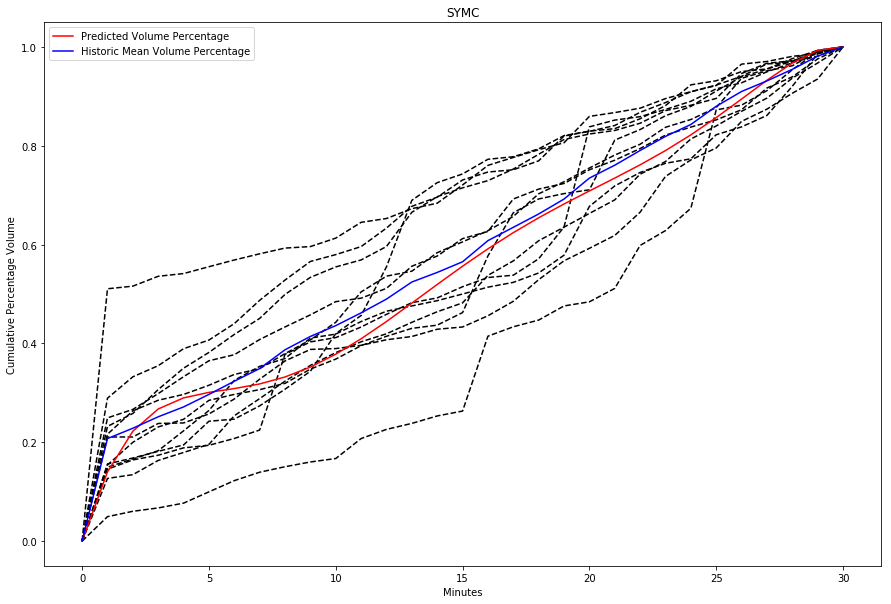

In [22]:
# Plot the comparison of the binwise mean and polynomial fitting result
from matplotlib import pyplot as plt
%matplotlib inline
def plot_cumper(St,mean,pred,name):
    plt.figure(figsize=(15,10))
    for i in range(len(St)):
        c=[0]+[np.sum(St[i,:j+1]) for j in range(len(St[i]))]
        plt.plot(c,'k--')
    c=[0]+[np.sum(pred[:j+1]) for j in range(len(pred))]
    plt.plot(c,'r',label='Predicted Volume Percentage')
    c=[0]+[np.sum(mean[:j+1]) for j in range(len(mean))]
    plt.plot(c,'b',label='Historic Mean Volume Percentage')
    plt.title(name)
    plt.xlabel('Minutes')
    plt.ylabel('Cumulative Percentage Volume')
    plt.legend()
plot_cumper(S_t,vol_mean,pred_mean,L[1])